In [1]:
import numpy as np
import pandas as pd
import torch
import numpy as np
import torchvision
from torchvision import transforms, models
from rembg import remove
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
import shutil
import time
import copy


print(os.listdir("input"))

['.DS_Store', 'test', 'train']


In [2]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


def create_submission(model, device, val_transforms, batch_size, data_root='input', test_dir='input/test/'):
    # создаем подпапку в папке test (чтобы imagefolder думал что это класс unknown)
    shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))
    test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    model.eval()

    test_predictions = []
    test_img_paths = []
    for inputs, labels, paths in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        test_predictions.append(
            torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
        test_img_paths.extend(paths)
        
    test_predictions = np.concatenate(test_predictions)

    assert len(test_predictions) == len(test_img_paths)

    return test_img_paths, test_predictions, test_dataloader


def save_submission(test_img_paths, test_predictions, threshold=0.5, input_path='input'):
    submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
    submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > threshold else 'cleaned')
    submission_df['id'] = submission_df['id'].str.replace(rf"{input_path}/test/unknown\\", '')
    submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
    submission_df.set_index('id', inplace=True)
    submission_df.head(n=6)
    submission_df.to_csv('submission.csv')
    print('Sub saved')
    return submission_df

In [15]:
def del_trees():
    try:
        shutil.rmtree('train/')
        shutil.rmtree('val/')
        shutil.rmtree('input/test/unknown')
    except FileNotFoundError:
        print('Пути уже удалены')


def create_val_train_dir(data_root='input', train_dir='train', val_dir='val', class_names=['cleaned', 'dirty']):
    # создаём обучающую и валидационную выборки
    for dir_name in [train_dir, val_dir]:
        for class_name in class_names:
            os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

    for class_name in class_names:
        source_dir = os.path.join(data_root, 'train', class_name)
        for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
            if i % 6 != 0:  # каждую 6 картинку кладём в папку для валидации
                dest_dir = os.path.join(train_dir, class_name) 
            else:
                dest_dir = os.path.join(val_dir, class_name)
            shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
    print('len train data class 0: ', len(os.listdir('train/cleaned/')))
    print('len train data class 1: ', len(os.listdir('train/dirty/')))
    print('len val data class 0: ', len(os.listdir('val/cleaned/')))
    print('len val data class 1: ', len(os.listdir('val/dirty/')))


def create_train_val_dataloaders(data_root='input', train_dir='train', val_dir='val',
                                 class_names=['cleaned', 'dirty'], batch_size=8):

    create_val_train_dir(data_root, train_dir, val_dir, class_names)
    # случайным образом вырезаем на картинке область 224 на 224
    # зеркальное отображение по горизонтали
    # переводим из pillow в tensor
    # нормализуем с параметрами МО и СКО для resnet18 для каждого канала RGB
    train_transforms = transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.RandomPerspective(distortion_scale=0.09, p=0.75, interpolation=3, fill=255),
        transforms.Resize((224, 224)),
        transforms.ColorJitter(brightness = 0.175,   
                               contrast   = 0.175,   
                               saturation = 0.195,
                               hue=(-0.5,0.5)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # сжимаем изображение до 224 на 224
    # переводим из pillow в tensor
    # нормализуем с параметрами МО и СКО для resnet18 для каждого канала RGB
    val_transforms = transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),
        transforms.Resize((224, 224)),
        transforms.ColorJitter(brightness = 0.175,   
                               contrast   = 0.175,   
                               saturation = 0.195,
                               hue=(-0.5,0.5)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # ImageFolder позваляет итерироваться по датасету
    # он выдает картинку и метку класса (название папки clean/dirty)
    # первый аргумент - папка с подпапками классов, второй аргумент - функция трансформации данных
    train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
    val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

    # создание объекта загрузчика данных
    # принимает набор данных, размер батча, перемешивание, кол-во подпроцессов обработки данных
    # drop_last=True говорит о том, что надо удалить последний неполный батч
    # получается 4 раза выводит тензор с размерами (8, 3, 224, 224) и метками (8)
    # без drop_last=True 4 раза выводит тензор с размерами (8, 3, 224, 224) и 1 раз (2, 3, 224, 224)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size, drop_last=True)
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size, drop_last=False)
    print(f'Размер train_dataloader: {len(train_dataloader)}, Размер train_dataset: {len(train_dataset)}')
    print(f'Размер val_dataloader: {len(val_dataloader)}, Размер val_dataset: {len(val_dataset)}')
    
    return train_dataloader, val_dataloader, train_transforms, val_transforms


def show_input(input_tensor, title=''):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)


def plot_curve(history, title=''):
    for experiment_id in history.keys():
        plt.plot(history[experiment_id], label=experiment_id)
    plt.legend()
    plt.title(title)

In [ ]:
def remove_background(input_path='input/', output_path='input_rmbg/'):
    os.makedirs(output_path, exist_ok=True)
    os.makedirs(output_path+'train/', exist_ok=True)
    os.makedirs(output_path+'train/cleaned/', exist_ok=True)
    os.makedirs(output_path+'train/dirty/', exist_ok=True)
    os.makedirs(output_path+'test/', exist_ok=True)
    
    # for train
    for path in os.listdir(input_path+'train/')[1:]:
        for pic in tqdm(os.listdir(input_path+'train/'+path)[1:]):
            with open(input_path+'train/'+path+'/'+pic, 'rb') as i:
                with open(output_path+'train/'+path+'/'+pic, 'wb') as o:
                    input = i.read()
                    output = remove(input)
                    o.write(output)
    # for test
    for pic in tqdm(os.listdir(input_path+'test/')[1:]):
        with open(input_path+'test/'+pic, 'rb') as i:
            with open(output_path+'test/'+pic, 'wb') as o:
                input = i.read()
                output = remove(input)
                o.write(output)

                
remove_background()

In [14]:
import cv2


class Remove_background_and_crop:
    
    def __init__(self,img):
        self.x00 = 0
        self.x00 = 0
        self.r00 = 0
        self.img = img
        self.mask = img
                
    def crop (self): 
            c_r_crop = (1.42*self.r00/2)
            self.img = self.img[int(self.y00)-int(c_r_crop):int(self.y00)+int(c_r_crop),int(self.x00)-int(c_r_crop):int(self.x00)+int(c_r_crop)]
            self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
            crop = self.img
            cv2.imwrite(image_folder,crop)
            h,w = self.img.shape[:2] 
            c = min(h,w)     
            for i in range (5,int(c/3),5): 
                    crop_img = self.img[i:h-i,i:w-i]    
                    cv2.imwrite(image_folder[:-4] +  '_Crop_' + str(i) + '.jpg',crop_img)
            image1 = self.img[0:int(h//2),0:int(w//2)]
            #Делим изображение на 4 части
            cv2.imwrite(image_folder[:-4] +  'image1' + '.jpg',image1)
            image2 = self.img[int(h//2):h,int(w//2):w]
            cv2.imwrite(image_folder[:-4] +  'image2' + '.jpg',image2)
            image3 = self.img[int(h//2):h,0:int(w//2)]
            cv2.imwrite(image_folder[:-4] +  'image3' + '.jpg',image3)
            image4 = self.img[0:int(h//2),int(w//2):w]
            cv2.imwrite(image_folder[:-4] +  'image4' + '.jpg',image4)
            
    def crop_test (self):
        c_r_crop = (1.42*self.r00/2)
        self.img = self.img[int(self.y00)-int(c_r_crop):int(self.y00)+int(c_r_crop),int(self.x00)-int(c_r_crop):int(self.x00)+int(c_r_crop)]
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(image_folder,self.img)       
            
    def find_circle(self):
        output = self.img.copy()    
        img = cv2.convertScaleAbs(self.img, alpha=1.2, beta=0.0)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 10,param1=10,param2=5,minRadius=40,maxRadius=250)
        
        if circles is not None: 
            #print('Координаты центра:',self.x00,self.y00)
            circles = np.round(circles[0, :]).astype("int")
            #print('Возможные координаты центра и радиусы:')
            #print(circles) 
                             
            for x, y, r in circles:
                if ((self.x00-15)<x<(self.x00+15)) and ((self.y00-15)<y<(self.y00+15)):
                    if r > self.r00: 
                        self.x00 = x
                        self.y00 = y
                        self.r00 = r
                        #print('Найдено совпадение:',x,y,r)
                    
            if self.r00==0: 
                #print('Тарелка не найдена','\n')
                ret,thresh = cv2.threshold(self.mask,235,255,0)
                contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)   
                c = max(contours, key=cv2.contourArea)
                (self.x00, self.y00), self.r00 = cv2.minEnclosingCircle(c)
            #print('Выбранные координаты центра:',self.x00,self.y00,self.r00)
            
    def findCoordinates(self):  
        ret,thresh = cv2.threshold(self.mask,235,255,0)        
        M = cv2.moments(thresh)
        self.x00 = int(M["m10"] / M["m00"])
        self.y00 = int(M["m01"] / M["m00"])
        
#    def findCenter(self):
#        c_r_crop = 124
#        self.img = self.img[int(self.y00)-int(c_r_crop):int(self.y00)+int(c_r_crop),int(self.x00)-int(c_r_crop):int(self.x00)+int(c_r_crop)]
                
    def remove_background(self):  
        mainRectSize = .08
        fgSize = .01
        img = self.img
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        new_h, new_w = img.shape[:2]
        mask = np.zeros(img.shape[:2], np.uint8)
        bg_w = round(new_w * mainRectSize)
        bg_h = round(new_h * mainRectSize)
        bg_rect = (bg_w, bg_h, new_w - bg_w, new_h - bg_h)
        fg_w = round(new_w * (1 - fgSize) / 2)
        fg_h = round(new_h * (1 - fgSize) / 2)
        fg_rect = (fg_w, fg_h, new_w - fg_w, new_h - fg_h)
        cv2.rectangle(mask, fg_rect[:2], fg_rect[2:4], color=cv2.GC_FGD, thickness=-1)
        bgdModel1 = np.zeros((1, 65), np.float64)
        fgdModel1 = np.zeros((1, 65), np.float64)
        cv2.grabCut(img, mask, bg_rect, bgdModel1, fgdModel1, 3, cv2.GC_INIT_WITH_RECT)
        cv2.rectangle(mask, bg_rect[:2], bg_rect[2:4], color=cv2.GC_PR_BGD, thickness=bg_w * 3)
        cv2.grabCut(img, mask, bg_rect, bgdModel1, fgdModel1, 10, cv2.GC_INIT_WITH_MASK)   
        mask_result = np.where((mask == 1) + (mask == 3), 255, 0).astype('uint8')
        masked = cv2.bitwise_and(img, img, mask=mask_result)
        masked[mask_result < 2] = [255, 255, 255] 
        self.img = masked
        self.mask = mask_result
    
for image_index in range (20):
    print("Complete dirty: ","{0:04}".format(image_index),"/0019", end="\r")
    image_folder = 'input_rmbg/train/dirty/{0:04}.jpg'.format(image_index) 
    img = cv2.imread(image_folder)
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop()    
print("\n\r", end="")    
    
for image_index in range (20):
    print ("Complete cleaned: ","{0:04}".format(image_index),"/0019", end="\r")
    image_folder = 'input_rmbg/train/cleaned/{0:04}.jpg'.format(image_index) 
    img = cv2.imread(image_folder)
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop()
print("\n\r", end="")

for image_index in range (744):
    print ("Complete test: ","{0:04}".format(image_index),"/0743", end="\r")
    image_folder = 'input_rmbg/test/{0:04}.jpg'.format(image_index) 
    img = cv2.imread(image_folder)
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop_test()
print("\n\r", end="") 

Complete dirty:  0019 /0019
Complete cleaned:  0019 /0019
Complete test:  0743 /0743


In [ ]:
del_trees()
data_root = 'input_rmbg'
train_dir = 'train'
val_dir = 'val'
class_names = ['cleaned', 'dirty']
batch_size=20

train_dataloader, val_dataloader, train_transforms, val_transforms = create_train_val_dataloaders(data_root, train_dir, val_dir,
                                                                                                  class_names, batch_size)
# X_batch, y_batch = next(iter(train_dataloader))

# for x_item, y_item in zip(X_batch, y_batch):
#     show_input(x_item, title=class_names[y_item])

In [20]:
def train_model(model, loss, optimizer, scheduler, num_epochs, device):

    val_loss_history = []
    val_accuracy_history = []
    train_loss_history = []
    train_accuracy_history = []

    for epoch in (pbar := tqdm(range(num_epochs))):
        # каждая эпоха имеет этап обучения и проверки
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()    # говорим планировщику что прошла 1 эпоха
                model.train()  # переводим модель в train mode
            else:
                dataloader = val_dataloader
                model.eval()   # переводим модель в evaluate mode

            running_loss = 0.
            running_acc = 0.

            # итерируемся по данным
            for inputs, labels in dataloader:
                inputs = inputs.to(device)  # переводим инпуты на device
                labels = labels.to(device)  # переводим метки на device

                optimizer.zero_grad()   # обнуляем градиент, чтобы он не накапливался

                # forward and backward
                # set_grad_enabled не сохраняет подсчет градиентов для фазы валидации
                # set_grad_enabled выполняет то же самое, что и torch.no_grad()
                # set_grad_enabled удобнее использовать, чтобы не повторять код для forward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()   # считаем градиент 
                        optimizer.step()    # считаем шаг градиентного спуска

                # накапливаем метрики для каждого батча
                running_loss += loss_value.item()   # item переводит на cpu
                running_acc += (preds_class == labels.data).float().mean().item()   # item переводит на cpu

            # считаем средние метрики для одной эпохи
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_accuracy_history.append(epoch_acc)
            else:
                train_loss_history.append(epoch_loss)
                train_accuracy_history.append(epoch_acc)

            pbar.set_description(f'Epoch: {epoch}')
            pbar.set_postfix_str(f'Accuracy: {epoch_acc: .3f}, \
                                 Loss: {epoch_loss: .3f}, GPU_Mem_alloc: {torch.cuda.memory_allocated()/1000000: .3f} MB, \
                                 GPU_Mem_cashed: {torch.cuda.memory_reserved()/1000000: .3f} MB')

    return val_accuracy_history, val_loss_history, train_accuracy_history, train_loss_history, model

accuracies = {}
losses = {}

In [21]:
# берем обученную модель
model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)

# замораживаем веса (полезно когда маленький датасет)
for param in model.parameters():
    param.requires_grad = False

# меняем последний fc слой, который содержал 1000 выходов
model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)   # amsgrad

# уменьшение LR в 0.1 раза каждые 7 эпох
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
accuracies['val_resnet152_1fc'], losses['val_resnet152_1fc'], accuracies['train_resnet152_1fc'], losses['train_resnet152_1fc'], net = \
    train_model(model, loss, optimizer, scheduler, num_epochs=100, device=device)

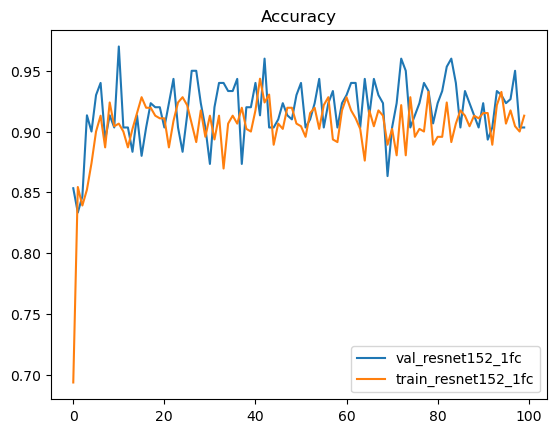

In [23]:
plot_curve(accuracies, title='Accuracy')

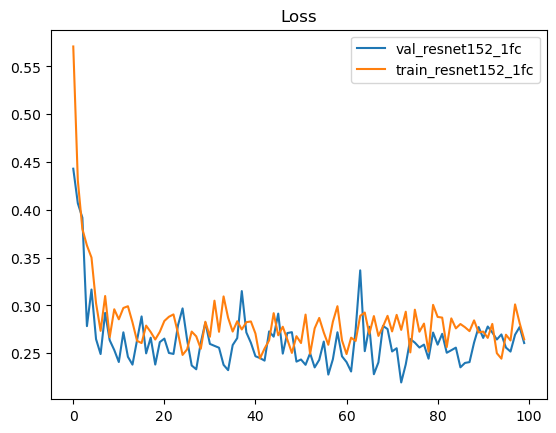

In [24]:
plot_curve(losses, title='Loss')

In [27]:
torch.save(net.state_dict(), 'resnet152.pt')

In [25]:
def conv3x3(in_channels, out_channels, stride=1):
    """
    return 3x3 Conv2d
    """
    return torch.nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=stride, padding=1, bias=False)


class ResidualBlock(torch.nn.Module):
    """
    Initialize basic ResidualBlock with forward propogation
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.act = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.act(out)
        return out


class ResNet(torch.nn.Module):
    """
    Initialize  ResNet with forward propogation
    """
    def __init__(self, block, layers, num_classes=10, avgkernal=8, in_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(in_channels, 16)
        self.bn = torch.nn.BatchNorm2d(16)
        self.relu = torch.nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, out_channels=16, blocks=layers[0], stride=1)
        self.layer2 = self.make_layer(block, out_channels=32, blocks=layers[1], stride=2)
        self.layer3 = self.make_layer(block, out_channels=64, blocks=layers[2], stride=2)
        self.avg_pool = torch.nn.AvgPool2d(avgkernal)  
        self.fc = torch.nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = torch.nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                torch.nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def calc_out_shape(input_matrix_shape, out_channels=64, kernel_size=3, stride=2, padding=1):
    w_out_height = (input_matrix_shape[-2] - kernel_size + 2 * padding) // stride + 1
    w_out_width = (input_matrix_shape[-1] - kernel_size + 2 * padding) // stride + 1
    out_shape = np.array([input_matrix_shape[0], out_channels, w_out_height, w_out_width])

    return out_shape

In [26]:
# берем обученную модель
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# замораживаем веса (полезно когда маленький датасет)
for param in model.parameters():
    param.requires_grad = False

# меняем последний fc слой, который содержал 1000 выходов
newmodel = torch.nn.Sequential(*(list(model.children())[:-2]))
batch = next(iter(train_dataloader))
print(newmodel(batch[0]).shape)
avgkernal = calc_out_shape(calc_out_shape(input_matrix_shape=[8,  16,  7,  7],
                                          out_channels=32,
                                          kernel_size=3,
                                          stride=2,
                                          padding=1))[-1]
newmodel.resnet = ResNet(ResidualBlock, [3, 3, 3], num_classes=2, avgkernal=avgkernal, in_channels=512)
print(newmodel)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
newmodel = newmodel.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(newmodel.parameters(), amsgrad=True, lr=1.0e-3)   # amsgrad

# уменьшение LR в 0.1 раза каждые 7 эпох
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

torch.Size([8, 512, 7, 7])
Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpla

In [ ]:
accuracies['val_bigresnet18+14'], losses['val_bigresnet18+14'], accuracies['train_bigresnet18+14'], losses['train_bigresnet18+14'], net = \
    train_model(newmodel, loss, optimizer, scheduler, num_epochs=100, device=device)

In [ ]:
test_dir = 'input_rmbg/test/'
test_img_paths, test_predictions, test_dataloader = create_submission(model, device, val_transforms, batch_size, data_root, test_dir)

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [30]:
save_submission(test_img_paths, test_predictions, threshold=0.5, input_path=data_root)

Sub saved


C:\Users\zekat\AppData\Local\Temp\ipykernel_18592\2951855661.py:40: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace(rf"{input_path}/test/unknown\\", '')
C:\Users\zekat\AppData\Local\Temp\ipykernel_18592\2951855661.py:41: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace('.jpg', '')


,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
...,...
0739,dirty
0740,dirty
0741,dirty


In [31]:
dataset_transforms = {
                      'orig': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),

                      '140': transforms.Compose([
    transforms.CenterCrop(140),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     '135': transforms.Compose([
    transforms.CenterCrop(135),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]), 
                      '130': transforms.Compose([
    transforms.CenterCrop(130),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '125': transforms.Compose([
    transforms.CenterCrop(125),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '120': transforms.Compose([
    transforms.CenterCrop(120),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '115': transforms.Compose([
    transforms.CenterCrop(115),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '110': transforms.Compose([
    transforms.CenterCrop(110),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '105': transforms.Compose([
    transforms.CenterCrop(105),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '100': transforms.Compose([
    transforms.CenterCrop(100),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     '95': transforms.Compose([
    transforms.CenterCrop(95),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '90': transforms.Compose([
    transforms.CenterCrop(90),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '85': transforms.Compose([
    transforms.CenterCrop(85),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '80': transforms.Compose([
    transforms.CenterCrop(80),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '75': transforms.Compose([
    transforms.CenterCrop(75),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),                                         
                       '70': transforms.Compose([
    transforms.CenterCrop(70),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),                                                           
                     }

In [32]:
data_root

'input_rmbg'

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder): #Создаем класс, он наследуется от ImageFolder, но изменяет его функцию get_item
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index) #Дополняем original_tuple путем для файла (.__getitem__(index))
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
df = pd.DataFrame
#Итерируемся по Crop'ам test датасета
for (i,tranforms) in dataset_transforms.items():
    test_dataset = ImageFolderWithPaths(data_root+'/test', tranforms) #Берем новый класс и получаем tuple из 3х значений
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=0) #Новый даталоадер с путями до изображений
    
    model.eval() #Переводим модель в состояние eval
    test_predictions = []  #Создаем пустой список предсказания 
    test_img_paths = [] #Пути до изображения
    for inputs, labels, paths in tqdm(test_dataloader): #Цикл по test_dataloader inputs - батч с изображением, lable - тут none, paths - пути до изображения  
        inputs = inputs.to(device) 
        labels = labels.to(device)  
        with torch.set_grad_enabled(False):
            preds = model(inputs) # Считаем предикшены
        test_predictions.append(
            torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()) #С помощью torch.nn.functional.softmax получаем вероятности, для первого класса [:,1], пеереводим тензор в .data, на .cpu(), в numpy 
        test_img_paths.extend(paths)
    test_predictions = np.concatenate(test_predictions)
    
    
    submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
    submission_df['id'] = submission_df['id'].str.replace(r'input_rmbg/test\\unknown\\', '') # input_rmbg/test\unknown\0000.jpg
    submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
    submission_df.set_index('id', inplace=True)
    
    try : df = df.merge(submission_df, how='inner', on='id') #Объединяем в один датафрейм
    except BaseException: # Для первой итерации
        df = submission_df 
    #submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.50 else 'cleaned')
    #submission_df.to_csv('submission_predict_{0}.csv'.format(i))
df.head(8)

In [35]:
df.mean(axis=1)

id
0000    0.669167
0001    0.854981
0002    0.863079
0003    0.931418
0004    0.793918
          ...   
0739    0.747468
0740    0.947020
0741    0.266095
0742    0.658062
0743    0.237402
Length: 744, dtype: float32

In [50]:
pd.DataFrame({'label': df.mean(axis=1).map(lambda pred: 'dirty' if pred > 0.498 else 'cleaned')})

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
...,...
0739,dirty
0740,dirty
0741,cleaned


In [49]:
pd.DataFrame({'label': df.mean(axis=1).map(lambda pred: 'dirty' if pred > 0.498 else 'cleaned')}).to_csv('submission.csv')

In [13]:
del_trees()